In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 64.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

from rdkit.Chem import Draw
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.Chem import Descriptors

from xgboost import XGBRegressor

**Import Data**

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("train:", train.shape)
print("test :", test.shape)

train.head(3)

train: (1681, 3)
test : (100, 2)


,ID,Canonical_Smiles,Inhibition
0,TRAIN_0000,Cl.OC1(Cc2cccc(Br)c2)CCNCC1,12.50
1,TRAIN_0001,Brc1ccc2OCCc3ccnc1c23,4.45
2,TRAIN_0002,CC1(CO)CC(=NO1)c2cc(c(F)cc2Cl)[N+](=O)[O-],4.92


**Exploratory Data Analysis**

In [ ]:
print(train.columns)
print(test.columns)

print(train.isna().sum())
print(test.isna().sum())

train["Inhibition"].describe()

Index(['ID', 'Canonical_Smiles', 'Inhibition'], dtype='object')
Index(['ID', 'Canonical_Smiles'], dtype='object')
ID                  0
Canonical_Smiles    0
Inhibition          0
dtype: int64
ID                  0
Canonical_Smiles    0
dtype: int64


,Inhibition
count,1681.000000
mean,33.221831
std,26.405830
min,0.000000
25%,10.900000
50%,29.000000
75%,50.200000
max,99.381547


 **SMILES string ->  RDKit molecule object **

In [ ]:
df=train
smiles = train['Canonical_Smiles'][1] # idx

# SMILES string을 RDKit molecule object 변환
mol = Chem.MolFromSmiles(smiles)

# 변환이 잘 되었는지 확인
if mol is not None:
    # 분자 구조 이미지 파일로 그리기
    img = Draw.MolToImage(mol)
    # 2D 분자 구조 이미지 저장
    img.save("molecule.png")
else:
    print("Invalid SMILES string")

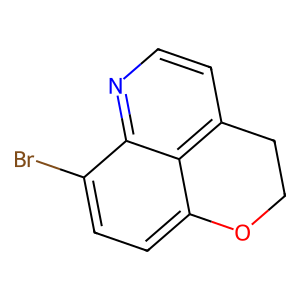

In [ ]:
img

In [ ]:
# 각 SMILES에서 원자 정보 추출
element_counter = Counter()
atom_counts = []
invalid_smiles = []
mol_weights = []

for idx, smi in enumerate(train['Canonical_Smiles']):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        invalid_smiles.append((idx, smi))
        continue
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    mol_weight = Descriptors.MolWt(mol)
    element_counter.update(atoms)
    atom_counts.append(len(atoms))
    mol_weights.append(mol_weight)

In [ ]:
# 평균 원자 수 (H 제외(heavy atoms), SMILES에만 포함된 원자)
df['atom_count'] = atom_counts
df['mol_weight'] = mol_weights

mean_atoms = np.mean([c for c in atom_counts if c is not None])

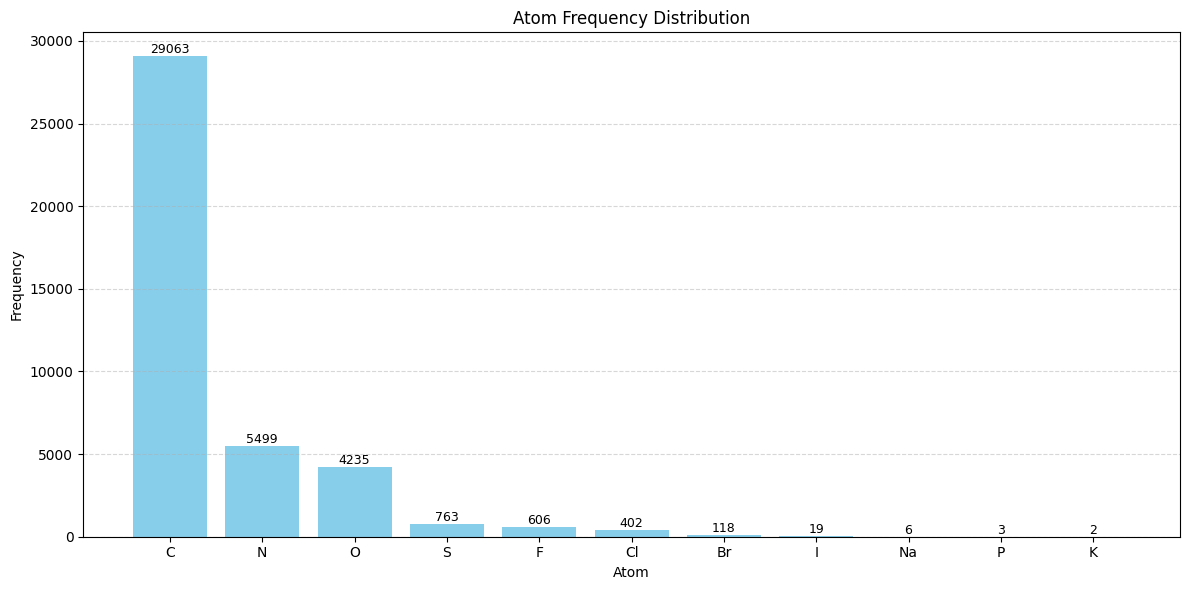

In [ ]:
# 원소 등장 빈도 (H 제외)
# plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))
elements, counts = zip(*element_counter.most_common())
bars = ax.bar(elements, counts, color='skyblue')
plt.title('Atom Frequency Distribution')
plt.xlabel('Atom')
plt.ylabel('Frequency')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

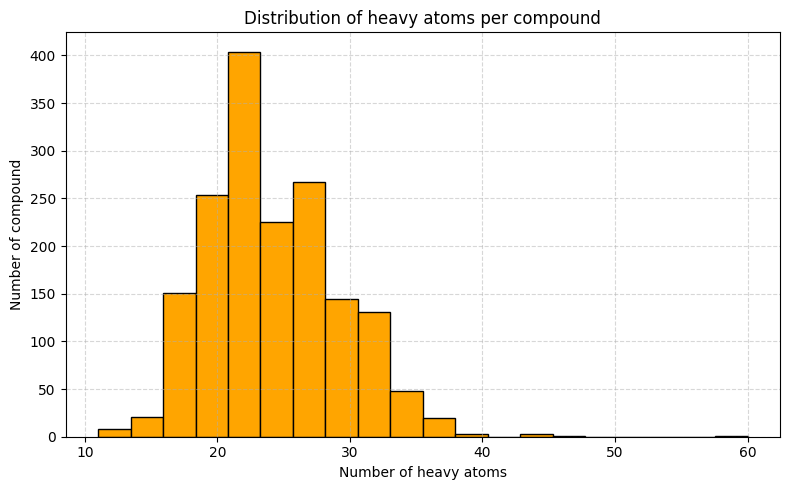

In [ ]:
# 화합물당 원자 수 히스토그램
plt.figure(figsize=(8, 5))
plt.hist(atom_counts, bins=20, color='orange', edgecolor='black')
plt.title('Distribution of heavy atoms per compound')
plt.xlabel('Number of heavy atoms')
plt.ylabel('Number of compound')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

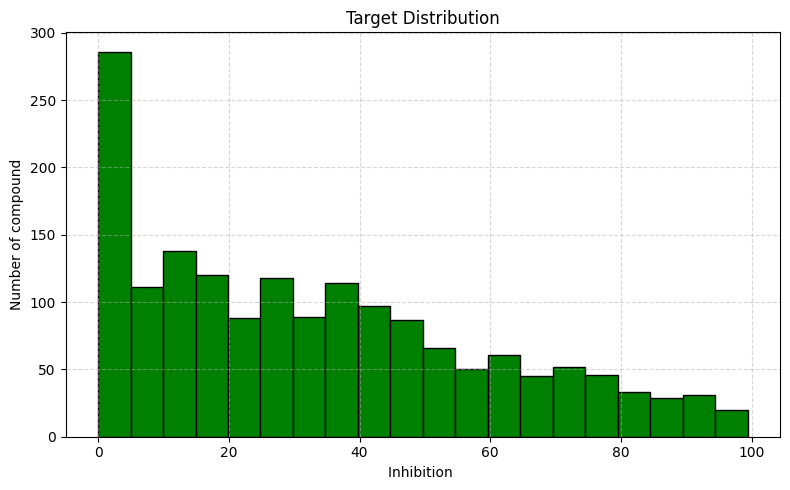

In [ ]:
# Inhibition 값 히스토그램
plt.figure(figsize=(8, 5))
# 5% 단위로 분리
plt.hist(df['Inhibition'], bins=20, color='green', edgecolor='black')
plt.title('Target Distribution')
plt.xlabel('Inhibition ')
plt.ylabel('Number of compound')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

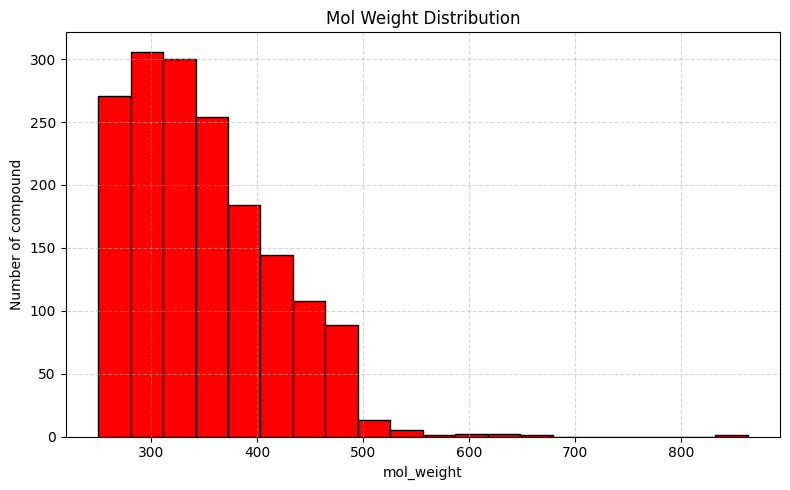

In [ ]:
# 분자량 히스토그램
plt.figure(figsize=(8, 5))
plt.hist(df['mol_weight'], bins=20, color='red', edgecolor='black')
plt.title('Mol Weight Distribution')
plt.xlabel('mol_weight')
plt.ylabel('Number of compound')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 통계 정보
print(f"Number of valid SMILES: {len(atom_counts)} / {len(df)}")
print(f"Number of Invalid SMILES: {len(invalid_smiles)}")
print(f"Average number of heavy atoms: {mean_atoms:.2f}")

Number of valid SMILES: 1681 / 1681
Number of Invalid SMILES: 0
Average number of heavy atoms: 24.22


**Correlation Analysis**

- Correlation between SMILES length and inhibition rate

- Correlation between molecular weight and inhibition rate

 Pearson 상관계수: 0.188
 p-value: 8.549e-15


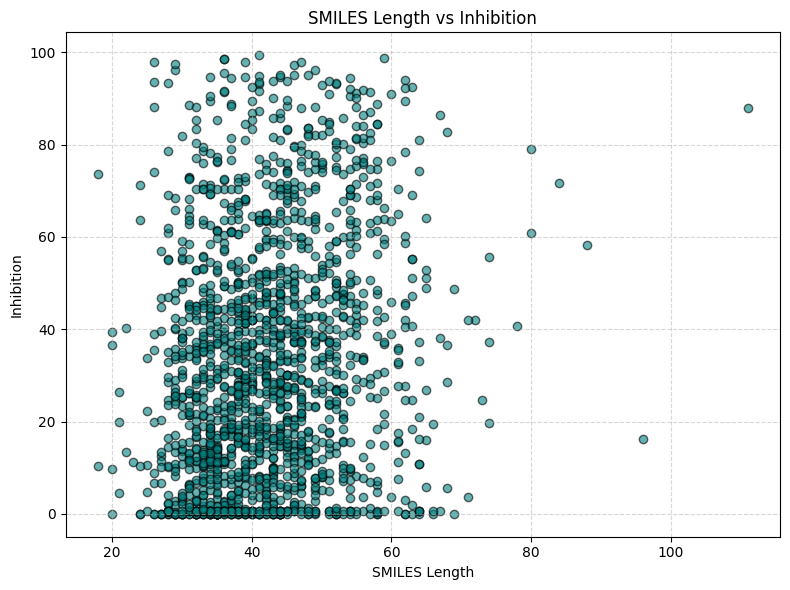

In [ ]:
# 데이터프레임: df['smiles'], df['target'] 가정
df['smiles_length'] = df['Canonical_Smiles'].apply(len)

# 상관계수 계산
corr, p_value = pearsonr(df['smiles_length'], df['Inhibition'])

print(f" Pearson 상관계수: {corr:.3f}")
print(f" p-value: {p_value:.3e}")
print("="*120)

# 산점도 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df['smiles_length'], df['Inhibition'], alpha=0.6, color='teal', edgecolors='k')
plt.title('SMILES Length vs Inhibition')
plt.xlabel('SMILES Length')
plt.ylabel('Inhibition')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

 Pearson 상관계수: 0.241
 p-value: 1.129e-23


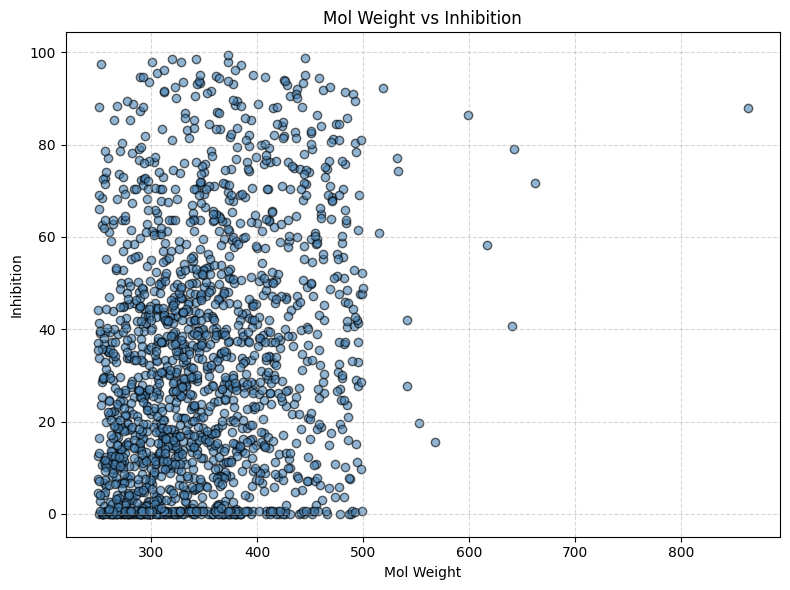

In [ ]:
# 상관계수 계산
corr, p_value = pearsonr(df['mol_weight'], df['Inhibition'])

print(f" Pearson 상관계수: {corr:.3f}")
print(f" p-value: {p_value:.3e}")
print("="*120)

# 산점도 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df['mol_weight'], df['Inhibition'], alpha=0.6, color='steelblue', edgecolors='k')
plt.title('Mol Weight vs Inhibition')
plt.xlabel('Mol Weight')
plt.ylabel('Inhibition')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Feature Engineering**

In [ ]:
def extract_full_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(3006)  # 6 + rdkit descs + morgan

    try:
        mol_wt = Descriptors.MolWt(mol)
        log_p = Descriptors.MolLogP(mol)
        h_donors = Descriptors.NumHDonors(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)
        tpsa = Descriptors.TPSA(mol)
        rot_bonds = Descriptors.NumRotatableBonds(mol)
        manual_feats = [mol_wt, log_p, h_donors, h_acceptors, tpsa, rot_bonds]
    except:
        manual_feats = [0.0] * 6

    rdkit_descs = []
    for name, func in Descriptors.descList:
        try:
            val = func(mol)
            rdkit_descs.append(float(val) if np.isfinite(val) else 0.0)
        except:
            rdkit_descs.append(0.0)
    rdkit_descs = np.nan_to_num(rdkit_descs)

    morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return np.concatenate([np.array(manual_feats), np.array(rdkit_descs), np.array(morgan)])


**Data Augmentation via SMILES Randomisation (Inhibition > 70%)**

In [ ]:
def randomize_smiles(smiles, n_aug=3):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    return [Chem.MolToSmiles(mol, doRandom=True) for _ in range(n_aug)]

def augment_high_inhibition_samples(df, threshold=70.0, n_aug=3):
    high_df = df[df['Inhibition'] > threshold].copy()
    aug_rows = []

    for _, row in high_df.iterrows():
        original = row['Canonical_Smiles']
        label = row['Inhibition']
        aug_smiles = randomize_smiles(original, n_aug=n_aug)
        for smi in aug_smiles:
            aug_rows.append({'Canonical_Smiles': smi, 'Inhibition': label})

    aug_df = pd.DataFrame(aug_rows)
    print(f" Total augmented samples: {len(aug_df)}")
    return pd.concat([df, aug_df], ignore_index=True)

**Data Preparation**

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')

In [ ]:
train_aug = augment_high_inhibition_samples(train, threshold=70.0, n_aug=3)
train_aug['Features'] = train_aug['Canonical_Smiles'].apply(extract_full_features)

X = np.stack(train_aug['Features'].values)
y_raw = train_aug['Inhibition'].values

# Stratified KFold용 bin 생성 (이 시점에서!)
train_aug['bin'] = pd.qcut(y_raw, q=5, labels=False, duplicates='drop')
print("bins:", train_aug["bin"].nunique())
train_aug["bin"].value_counts().sort_index()

 Total augmented samples: 630
bins: 5


,count
bin,
0,463
1,462
2,462
3,464
4,460


**Ensemble Training (XGB + Gradient Boosting)**

In [ ]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_preds_gb = np.zeros(len(train_aug))
oof_preds_xgb = np.zeros(len(train_aug))
oof_true = np.zeros(len(train_aug))


test = pd.read_csv("test.csv")
test['Features'] = test['Canonical_Smiles'].apply(extract_full_features)
X_test = np.stack(test['Features'].values)
test_pred_gb = np.zeros(len(test))
test_pred_xgb = np.zeros(len(test))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, train_aug['bin'])):
    print(f"\n📂 Fold {fold + 1}")

    X_train, X_val = X[tr_idx], X[val_idx]
    y_train, y_val = y_raw[tr_idx], y_raw[val_idx]

    # Gradient Boosting
    model_gb = GradientBoostingRegressor(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        max_features="sqrt",
        random_state=42
    )
    model_gb.fit(X_train, y_train)
    pred_gb = model_gb.predict(X_val)
    oof_preds_gb[val_idx] = pred_gb
    test_pred_gb += model_gb.predict(X_test) / n_folds

    #  XGBoost
    model_xgb = XGBRegressor(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        verbosity=0
    )
    model_xgb.fit(X_train, y_train)
    pred_xgb = model_xgb.predict(X_val)
    oof_preds_xgb[val_idx] = pred_xgb
    test_pred_xgb += model_xgb.predict(X_test) / n_folds

    # Fold Evaluation
    pred_ensemble = (pred_gb + pred_xgb )/2
    oof_true[val_idx] = y_val

    mse = mean_squared_error(y_val, pred_ensemble)
    rmse = np.sqrt(mse)
    nrmse = rmse / 100
    corr, _ = pearsonr(y_val, pred_ensemble)
    final_score = 0.5 * (1 - min(nrmse, 1)) + 0.5 * corr

    print(f" RMSE       : {rmse:.4f}")
    print(f" NRMSE      : {nrmse:.4f}")
    print(f" Correlation: {corr:.4f}")
    print(f" Fold Score : {final_score:.4f}")


📂 Fold 1
 RMSE       : 18.0887
 NRMSE      : 0.1809
 Correlation: 0.8312
 Fold Score : 0.8252

📂 Fold 2
 RMSE       : 18.1090
 NRMSE      : 0.1811
 Correlation: 0.8348
 Fold Score : 0.8269

📂 Fold 3
 RMSE       : 18.0246
 NRMSE      : 0.1802
 Correlation: 0.8383
 Fold Score : 0.8290

📂 Fold 4
 RMSE       : 18.9901
 NRMSE      : 0.1899
 Correlation: 0.8152
 Fold Score : 0.8126

📂 Fold 5
 RMSE       : 18.9618
 NRMSE      : 0.1896
 Correlation: 0.8056
 Fold Score : 0.8080


** Evaluation**

In [ ]:
print("OOF Evaluation:")
oof_ensemble = (oof_preds_gb  + oof_preds_xgb )/2
mse = mean_squared_error(oof_true, oof_ensemble)
rmse = np.sqrt(mse)
nrmse = rmse / 100
corr, _ = pearsonr(oof_true, oof_ensemble)
final_score = 0.5 * (1 - min(nrmse, 1)) + 0.5 * corr

print(f" RMSE       : {rmse:.4f}")
print(f" NRMSE      : {nrmse:.4f}")
print(f" Correlation: {corr:.4f}")
print(f" Final Score: {final_score:.4f}")


OOF Evaluation:
 RMSE       : 18.4400
 NRMSE      : 0.1844
 Correlation: 0.8250
 Final Score: 0.8203
